## Imports

In [1]:
import matplotlib.pyplot as plt
from common import *
from mcmceva import plot
from hkvpy import plotting
from scipy.interpolate import interp1d
import seaborn as sns
import pandas as pd

plotting.set_rcparams()

In [2]:
directories = load_directories()
project = load_anduryl_project()

In [3]:
trib_mapping = {
    "Chaudfontaine": "Vesdre",
    "Chooz": "French\nMeuse",
    "Gendron": "Lesse",
    "Martinrive": "Ambleve",
    "Salzinnes": "Sambre",
    "Tabreux": "Ourthe",
    "Membre": "Semois",
    "Stah": "Roer",
    "Meerssen": "Geul",
    "Goch": "Niers",
}

order = [
    "Chooz",
    "Membre",
    "Salzinnes",
    "Gendron",
    "Martinrive",
    "Tabreux",
    "Chaudfontaine",
    "Meerssen",
    "Stah",
    "Goch",
]

## Calibration results

In [4]:

pps_tot = {}
experts = project.experts.get_exp("actual")
for i, expert in enumerate(experts):

    pps = []
    for item, consider, real in zip(
        project.items.ids, project.items.get_idx("seed"), project.items.realizations
    ):
        if not consider:
            continue
        x = project.assessments.estimates[expert][item].metalog.cdf(real)
        #         print(expert, item, x)
        pps.append(x)

    pps_tot[expert] = pps


C:\Python\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 10.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


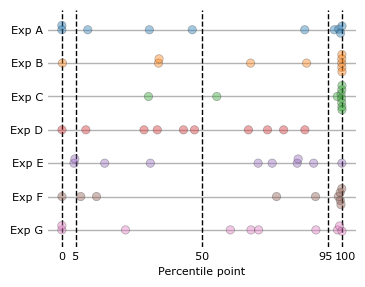

In [5]:
df = pd.DataFrame(pps_tot)
df.columns.name = "Expert"
# df.columns = pd.MultiIndex.from_product([['pp'], df.columns], names='')
df.index.name = "Item"
df = pd.DataFrame(df.stack(), columns=["Percentile point"]).reset_index()

fig, ax = plt.subplots(figsize=(20 / 2.54, 17 / 2.54), constrained_layout=True)

sns.swarmplot(data=df, x="Percentile point", y="Expert", ax=ax, alpha=0.4, size=6, linewidth=0.5)
# sns.stripplot(data=df, x='Percentile point', y='Expert', ax=ax, alpha=0.5, size=5, jitter=0.3)

for i in range(7):
    ax.axhline(i, color="0.7", zorder=-10, lw=1)

for p in [0.0, 0.05, 0.5, 0.95, 1.0]:
    ax.axvline(p, color="k", ls="--", lw=1, zorder=-9)

ax.set(
    yticks=np.arange(len(experts)),
    yticklabels=['Exp ' + exp[-1] for exp in experts],
    ylim=(6.5, -0.6),
    #     xlabel="Percentile point",
    xticks=[0.0, 0.05, 0.5, 0.94, 1.01],
    xticklabels=[0, 5, 50, 95, 100],
    ylabel="",
)

fig.set_size_inches(9 / 2.54, 7 / 2.54)

plt.tick_params(length=0)

ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)

# fig.savefig(directories["figuredir"] / "expert_calibration.pdf")

## Estimates per expert

In [8]:
plotdata_gl = project.results["GL"].get_plot_data(full_dm_cdf=False)
plotdata_eq = project.results["EQ"].get_plot_data(full_dm_cdf=False)

In [9]:
plt.rcParams["axes.linewidth"] = 0.5
plt.rcParams["axes.labelsize"] = 9
plt.rcParams["axes.titlesize"] = 9
plt.rcParams["xtick.labelsize"] = 9
plt.rcParams["ytick.labelsize"] = 9
plt.rcParams["grid.alpha"] = 0.25
plt.rcParams["legend.handletextpad"] = 0.4
plt.rcParams["legend.fontsize"] = 8
plt.rcParams["legend.labelspacing"] = 0.2
plt.rcParams["legend.fancybox"] = False

plt.rcParams["font.size"] = 9

plt.rcParams["lines.linewidth"] = 1.5  # line width in points
plt.rcParams["lines.markeredgewidth"] = 0
plt.rcParams["lines.markersize"] = 5

# plt.rcParams["figure.dpi"] = 50

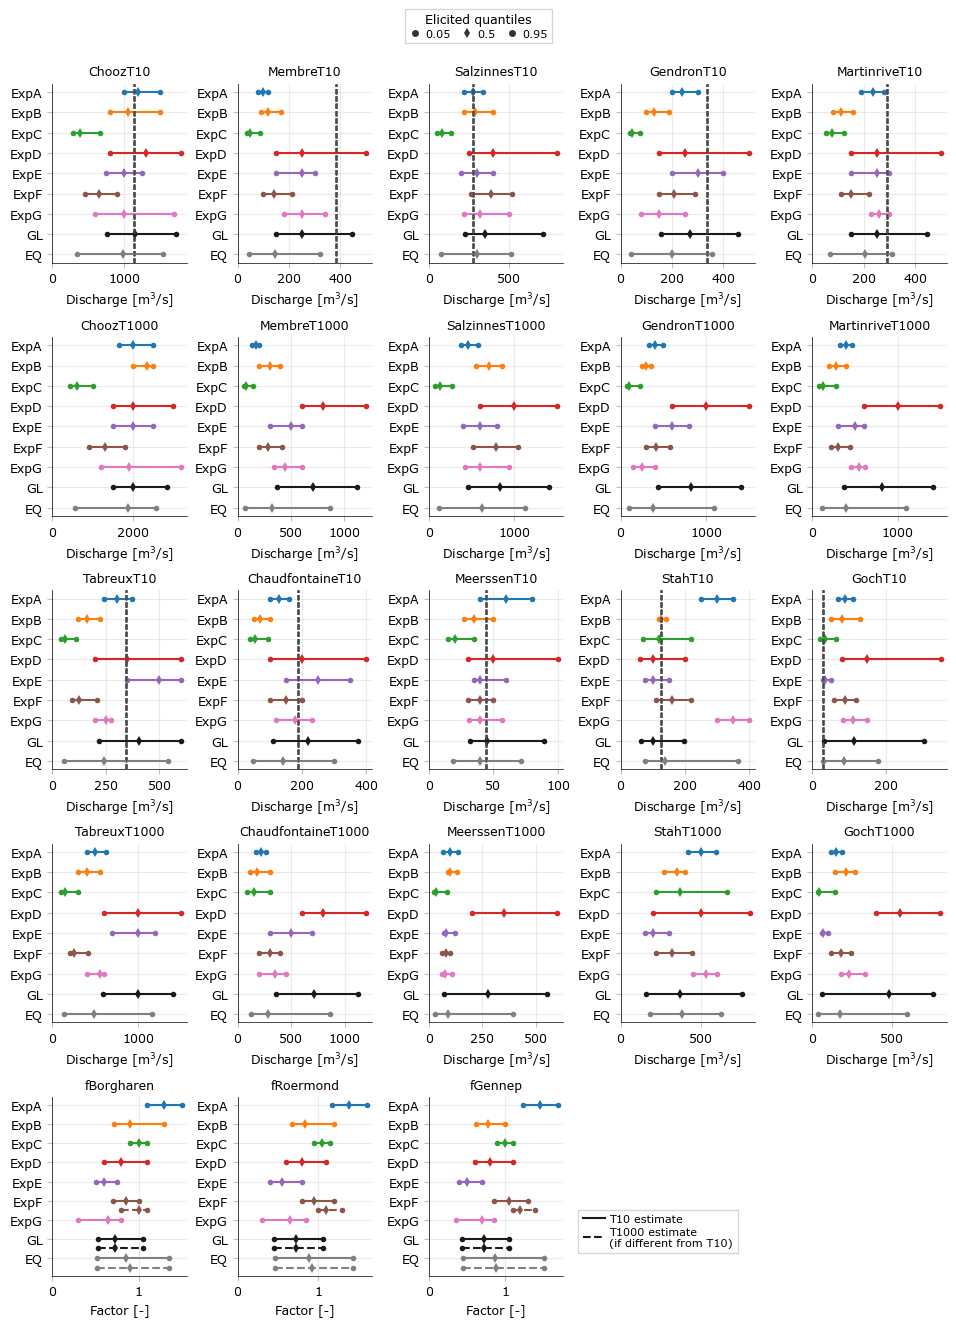

In [10]:
colors = {
    "ExpA": "C0",
    "ExpB": "C1",
    "ExpC": "C2",
    "ExpD": "C3",
    "ExpE": "C4",
    "ExpF": "C5",
    "ExpG": "C6",
    "GL": "0.1",
    "EQ": "0.5",
}


def adjust_ax(ax):
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.tick_params(axis="y", color="0.75")
    ax.tick_params(axis="x", color="0.75")
    ax.grid()


fig, axs = plt.subplots(ncols=5, nrows=5, figsize=(24 / 2.54, 32 / 2.54), constrained_layout=True)

# Return period ranges
for i, loc in enumerate(order):
    for j, expert in enumerate(project.experts.ids):
        for iextra, rp in enumerate(["T10", "T1000"]):

            irow = (i // 5) * 2 + iextra
            icol = i % 5

            ax = axs[irow, icol]
            plotdata = plotdata_gl if expert != "EQ" else plotdata_eq
            pd = plotdata[(loc + rp, expert)]

            ax.plot(
                [pd.estimates[0.05], pd.estimates[0.95]], [-j, -j], color=colors[expert], marker="o", ms=4
            )
            ax.plot([pd.estimates[0.50]], [-j], color=colors[expert], marker="d", ms=5)

            if j == 0:
                ax.set_title(loc + rp)
                ax.set_xlabel("Discharge [m$^3$/s]")
                
            if rp == 'T10':
                ax.axvline(project.items.realizations[project.items.ids.index(loc+rp)], ls='--', color='0.3', lw=1)

# Factor range
for i, loc in enumerate(["Borgharen", "Roermond", "Gennep"]):
    for j, expert in enumerate(project.experts.ids):
        irow = 4
        icol = i % 5

        ax = axs[irow, icol]
        plotdata = plotdata_gl if expert != "EQ" else plotdata_eq
        for jextra, rp in enumerate(["T10", "T1000"]):
            jextra *= 0.5

            if rp == "T1000" and expert not in ["ExpF", "GL", "EQ"]:
                continue

            pd = plotdata[("f" + loc + rp, expert)]

            ax.plot(
                [pd.estimates[0.05], pd.estimates[0.95]],
                [-j - jextra, -j - jextra],
                color=colors[expert],
                marker="o",
                ms=4,
                ls='--' if jextra > 0.0 else '-'
            )
            ax.plot([pd.estimates[0.50]], [-j - jextra], color=colors[expert], marker="d", ms=5)

        if j == 0:
            ax.set_title("f" + loc)
            
    ax.set_xlabel('Factor [-]')
            

for ax in np.ravel(axs):
    ax.set_yticks(np.arange(-9, 0) + 1)
    ax.set_yticklabels(project.experts.ids[::-1])
    adjust_ax(ax)
    ax.set_xlim(0)

lg = fig.legend(
    [ax.plot([], [], marker=marker, color="0.2", ls="")[0] for marker, ms in zip(['o', 'd', 'o'], [4, 5, 4])],
    [0.05, 0.5, 0.95],
    'lower center',
    title="Elicited quantiles",
    ncol=3,
    bbox_to_anchor=(0.5, 1.01),
    handlelength=1,
    columnspacing=1,
)

fig.delaxes(axs[4, 3])
fig.delaxes(axs[4, 4])

fig.legend(
    [ax.plot([], [], ls=ls, color="0.1")[0] for ls in ['-', '--']],
    ['T10 estimate', 'T1000 estimate\n(if different from T10)'],
    'lower left',
#     title="Factor estimates",
    bbox_to_anchor=(0.6, 0.05),
)



## Discharge per area, according to the experts

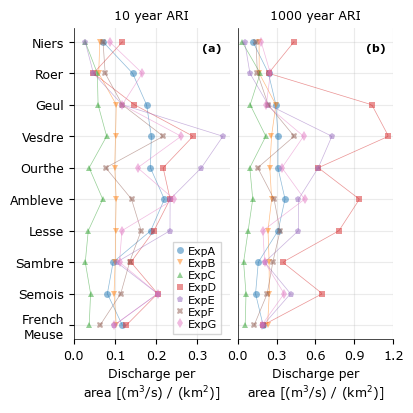

In [11]:
areas = {
    "Chaudfontaine": 688.5570777,
    "Chooz": 10161.61632,
    "Gendron": 1281.075448,
    "Martinrive": 1065.919302,
    "Salzinnes": 2875.413101,
    "Tabreux": 1609.09745,
    "Membre": 1225.660256,
    "Stah": 2096.695436,
    "Meerssen": 338.6815999,
    "Goch": 1265.634182,
}

markers = ["o", "v", "^", "s", "p", "X", "d"]

# t1000 = project.assessments.get_array(experts=project.experts.get_exp('actual'))[:, 1, order+10].T
# t10 = project.assessments.get_array(experts=project.experts.get_exp('actual'))[:, 1, order].T

fig, axs = plt.subplots(figsize=(10 / 2.54, 10 / 2.54), ncols=2, sharey=True)  # , constrained_layout=True)

experts = project.experts.get_exp("actual")

t10s = []
t1000s = []
for i, trib in enumerate(order):
    area = areas[trib]

    t10s.append(
        (
            np.array([project.assessments.estimates[exp][trib + "T10"].estimates[0.5] for exp in experts])
            / area
        )
    )
    t1000s.append(
        (
            np.array([project.assessments.estimates[exp][trib + "T1000"].estimates[0.5] for exp in experts])
            / area
        )
    )

t10s = np.stack(t10s)
t1000s = np.stack(t1000s)

ms = 5

for i, exp in enumerate(experts):
    axs[0].plot([], [], ls="", marker=markers[i], alpha=0.5, lw=0.5, label=exp, ms=ms)

    axs[0].plot(
        t10s[:, i], np.arange(len(t10s)), ls="", marker=markers[i], alpha=0.5, lw=0.5, color=f"C{i}", ms=ms
    )
    axs[1].plot(
        t1000s[:, i],
        np.arange(len(t1000s)),
        ls="",
        marker=markers[i],
        alpha=0.5,
        lw=0.5,
        color=f"C{i}",
        ms=ms,
    )

    ygrid = np.linspace(0, 9, 201)
    axs[0].plot(
        interp1d(np.arange(len(t10s)), t10s[:, i], kind="linear")(ygrid), ygrid, color=f"C{i}", lw=.5, alpha=0.5
    )
    axs[1].plot(
        interp1d(np.arange(len(t1000s)), t1000s[:, i], kind="linear")(ygrid),
        ygrid,
        color=f"C{i}",
        lw=.5,
        alpha=0.5,
    )


for ax in axs:
    ax.set(yticks=np.arange(10)[::-1], yticklabels=[trib_mapping[trib] for trib in order][::-1])
    ax.grid()
    ax.set_xlim(0.0)
    ax.set_xlabel("Discharge per\narea [(m$^3$/s) / (km$^2$)]")

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

# axs[0].set_xlim

axs[0].set(title="10 year ARI")#, xlim=(0, 0.4), xticks=np.linspace(0, 0.4, 5))
axs[1].set(title="1000 year ARI", xlim=(0, 1.2), xticks=np.linspace(0, 1.2, 5))

axs[1].yaxis.set_tick_params(length=0)
axs[0].legend(loc="lower left", bbox_to_anchor=(0.6, 0.00), handlelength=0.5)

plt.tight_layout(pad=0.0, w_pad=-0.2)

plot.add_panel_letters(axs, pos=(0.95, 0.95), ha='right', fmt='({})')

# fig.savefig(directories["figuredir"] / "discharge_per_area.pdf")